In [6]:
%load_ext autoreload
%autoreload 2

import __confing
__confing.change_to_root_folder()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current directory: c:\Users\Leo\OneDrive\Escritorio\Final Proyect


In [7]:
try:
    __confing.execute_notebook('notebooks/0_data_extract.ipynb')
except:
    pass

In [8]:
import pandas as pd

from src.feature_selection import fast_fill
from src import data_procces as dp

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.metrics import classification_report, roc_auc_score ,confusion_matrix
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df=pd.read_csv(r'data\custom\all_waves.csv')
df = df.loc[df['paagey'] >= 50]
target='pahosp1y'

selected=[
    'pahosp1y',     'pahipe_m',     'padadage',     'pamomage', 
    'pahibpe',      'palunge_m',    'pacholst',     'pagrossaa', 
    'paosleep',     'pafallinj',    'pacancre',     'paswell', 
    'pachair',      'parafaany',    'pawheeze',     'paagey', 
    'paarthre',     'padiabe',      'parjudg',      'paweight', 
    'paclims',      'pastroke',     'pabathehlp',   'pasmokev', 
    'pahearaid',    'pameds',       'paheight',     'paglasses', 
    'paeat',        'papaina',      'pagender',     'padrinkb'
]
print(f"There are {len(selected)} features selected")

FileNotFoundError: [Errno 2] No such file or directory: 'data\\custom\\all_waves.csv'

In [ ]:
df3 = df.where(df['cpindex'] <=  107.69).dropna(subset=['cpindex'])

df_s = df3.dropna(subset=[target]) 

df_s = df_s[selected].copy()

nulls = df_s.isnull().sum(axis=1) / len(df.columns)
df_s = df_s[(df_s[target] != 0) | (nulls <= 0.5)]

In [ ]:
y = df_s[target]
X = df_s.drop(target,axis=1)

X = fast_fill(X)
X=X.sort_index(axis=1)

In [ ]:
scaler = StandardScaler()
X=scaler.fit_transform(X)

transformer = PowerTransformer(method='yeo-johnson')
X=transformer.fit_transform(X)
pass

In [ ]:
X_train, X_test, y_train, y_test=dp.split_data(X, y, test_size=0.2, random_state=40)

X_train, y_train = dp.apply_smote(X_train, y_train)

In [ ]:
zeros=y_train.value_counts()[0]
unos=y_train.value_counts()[1]

params={
    'max_depth': 8, 
    'subsample': 0.759545947005226,
    'colsample_bytree': 0.9075616505206274, 
    'eta': 0.05568753700048324, 
    'min_child_weight': 4, 
    'learning_rate': 0.0799908981133205, 
    'n_estimators': 571,
    'scale_pos_weight': (zeros/unos)-1.6 #-1.6
}

In [ ]:
model = XGBClassifier(**params)
model.fit(X_train, y_train)
pass

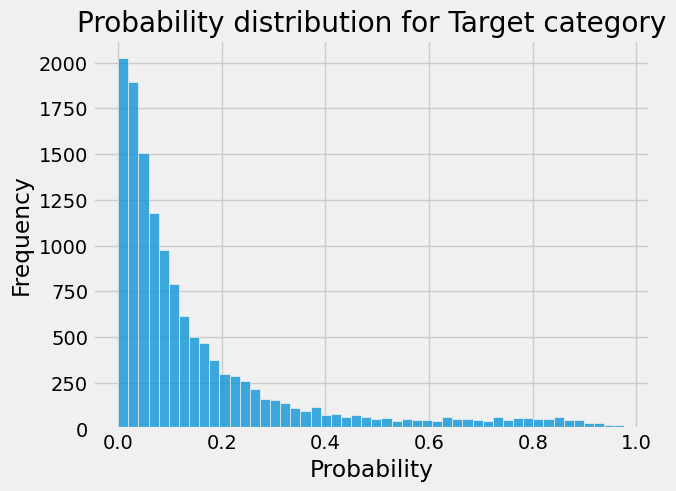

In [ ]:
with plt.style.context('fivethirtyeight'):
    sns.histplot(model.predict_proba(X_test)[:,1], bins=50)
    plt.title("Probability distribution for Target category")
    plt.xlabel("Probability")
    plt.ylabel("Frequency")
    plt.show()

In [ ]:
test_predictions = model.predict(X_test)
print(classification_report(y_test, test_predictions))
print()
test_predictions = model.predict(X_test)
print(confusion_matrix(y_test, test_predictions))
print()
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC = {auc}')

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     12305
         1.0       0.75      0.61      0.67      1419

    accuracy                           0.94     13724
   macro avg       0.85      0.79      0.82     13724
weighted avg       0.94      0.94      0.94     13724


[[12022   283]
 [  553   866]]

AUC = 0.8972472043798692
